In [1]:
#Pre-Processing
import os
import re
import torch
import random
import itertools

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

# For visualising metrics
from visdom import Visdom

# For visualising gradients plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print("The device found: "+str(device))

The device found: cuda


In [3]:

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

In [4]:
path='C:\\Users\\deepa\\Conversational Agents\\Datasets'
dataset='cornell movie-dialogs corpus'

data_folder=os.path.join(path,dataset)

print("The final data corpus folder: "+str(data_folder))

The final data corpus folder: C:\Users\deepa\Conversational Agents\Datasets\cornell movie-dialogs corpus


In [5]:
def get_lines_conversations():
    """
    Loads movie lines and conversations from the dataset.
    
    data_folder: Destination where conversations and lines are stored.
    
    movie_lines: Consist of movie lines as given by the dataset.
    movie_conversations: Consist of movie conversations as given by the dataset.
    
    """
    f=open(os.path.join(data_folder,'movie_lines.txt'),'r')
    movie_lines=f.read().splitlines()
    f.close()
    
    f=open(os.path.join(data_folder,'movie_conversations.txt'),'r')
    movie_conversations=f.read().splitlines()
    f.close()
    
    return movie_lines,movie_conversations


In [6]:
movie_lines,movie_conversations=get_lines_conversations()

print("Number of distinct lines: "+str(len(movie_lines)))
print("Number of conversations: "+str(len(movie_conversations)))
print("Average Number of lines per conversations: "+str(len(movie_lines)/len(movie_conversations)))

print(movie_lines[0])
print(movie_conversations[0])

Number of distinct lines: 304713
Number of conversations: 83097
Average Number of lines per conversations: 3.6669554857576085
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']


In [7]:
def loadLines(movie_lines,fields):
    lines={}
    for line in movie_lines:
        values=line.split(" +++$+++ ")
        
        lineVals={}
        
#         print("values"+str(len(values)))
#         print("fields"+str(len(fields)))
              
        for i,field in enumerate(fields):
            lineVals[field]=values[i]
        
        lines[lineVals['lineID']]=lineVals
    
    return lines

def loadConversations(movie_conversations,lines,fields):
    conversations=[]
    
    for convo in movie_conversations:
        values=convo.split(" +++$+++ ")
        conVals={}
       
        for i,field in enumerate(fields):
            conVals[field]=values[i]
        
        lineIDs=eval(conVals["utteranceIDs"])
        
        conVals["lines"]=[]
        
        for lineID in lineIDs:
            conVals["lines"].append(lines[lineID])
        conversations.append(conVals)
        
    return conversations

def sentencePairs(conversations):
    qr_pairs=[]
    
    for conversation in conversations:
        for i in range(len(conversation["lines"])-1):
            query=conversation["lines"][i]["text"].strip()
            response=conversation["lines"][i+1]["text"].strip()
            
            if query and response:
                qr_pairs.append([query,response])
        
    return qr_pairs

In [8]:
lines={}
conversations=[]
qr_pairs=[]

movie_lines_fields=["lineID","characterID","movieID","character","text"]
movie_convo_fields=["charcaterID","character2ID","movieID","utteranceIDs"]

lines=loadLines(movie_lines,movie_lines_fields)
conversations=loadConversations(movie_conversations,lines,movie_convo_fields)
qr_pairs=sentencePairs(conversations)

print("The number of query-response pairs are: "+str(len(qr_pairs)))

The number of query-response pairs are: 221282


In [9]:
PAD_Token=0
START_Token=1
END_Token=2

class Vocabulary:
    def __init__(self):
        self.trimmed=False
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.index2word[self.num_words]=word
            self.word2count[word]=1
            self.num_words=self.num_words+1
        else:
            self.word2count[word]+=1
            
    def trim(self,min_count):
        
        if self.trimmed:
            return
        self.trimmed=True
        
        keep_words=[]
        
        for word,freq in self.word2count.items():
            if freq>=min_count:
                keep_words.append(word)
        
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
        for word in keep_words:
            self.addWord(word)

In [10]:
Max_Length=10

def normalizeString(s):
    s=s.lower().strip()
    s=re.sub(r"([.!?])", r" \1", s)
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s=re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(qr_pairs):
    
    for qr_pair in qr_pairs:
        qr_pair[0]=normalizeString(qr_pair[0])
        qr_pair[1]=normalizeString(qr_pair[1])
    
    voc=Vocabulary()
    return voc,qr_pairs

def filterPair(pair):
    return len(pair[0].split(" "))<Max_Length and len(pair[1].split(" "))<Max_Length

def filterPairs(qr_pairs):
    return [pair for pair in qr_pairs if filterPair(pair)]

def prepareDataset(qr_pairs):
    voc, qr_pairs=readVocs(qr_pairs)
    qr_pairs=filterPairs(qr_pairs)
       
    for pair in qr_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
#     print("Number"+str(voc.num_words))
    return voc,qr_pairs

In [11]:
voc, pairs=prepareDataset(qr_pairs)

In [12]:
Min_Count=3

def trimRareWords(voc,qr_pairs):
    
    voc.trim(Min_Count)
    keep_pairs=[]
    
    for pair in qr_pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        
        keep_input=True
        keep_output=True
        
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input=False
                break
        
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output=False
                break
                
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    return keep_pairs

pairs=trimRareWords(voc,pairs)

In [13]:
def indexesFromSentence(voc,sentence):
    return [voc.word2index[word] for word in sentence.split(" ")]+[END_Token]

def zeroPadding(l,fillValue=PAD_Token):
    return list(itertools.zip_longest(*l,fillvalue=fillValue))

def binaryMatrix(l,value=PAD_Token):
    m=[]
    for i,seq in enumerate(l):
        m.append([])
        for token in seq:
            if token==value:
                m[i].append(0)
            else:
                m[i].append(1)
        
    return m

def inputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    lengths=torch.tensor([len(index) for index in indexes_batch])
    padList=zeroPadding(indexes_batch)
    padVar=torch.LongTensor(padList)
    return lengths,padVar

def outputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    max_target_len=max([len(index) for index in indexes_batch])
    padList=zeroPadding(indexes_batch)
    mask=binaryMatrix(padList)
    mask=torch.ByteTensor(mask)
    padVar=torch.LongTensor(padList)
    return max_target_len, mask, padVar

def batch2TrainData(voc,pair_batch):
    #sort function see 
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

    input_batch=[]
    output_batch=[]
    
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    
    input_lengths,tokenised_input=inputVar(voc,input_batch)
    max_out_length,mask,tokenised_output=outputVar(voc,output_batch)
    return tokenised_input,input_lengths,tokenised_output,mask,max_out_length

batch_size=10
batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(10)]
input_lengths, tokenised_input, max_out_length, mask, tokenised_output=batches[0]

print(tokenised_input)
print(tokenised_input)
print(mask)
print(input_lengths.size())
print(max_out_length)


tensor([8, 8, 7, 7, 7, 5, 4, 3, 3, 3])
tensor([8, 8, 7, 7, 7, 5, 4, 3, 3, 3])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=torch.uint8)
torch.Size([8, 10])
tensor([[  34,   25,    7,  318,  197,  188,   92,   50,  266, 1245],
        [6326,  200,  424,   42,  117,    4,    7,  881,   95, 4008],
        [   7, 1525,   83,   53,  669,    4,  123,    6,    4,   56],
        [   6,    4,   63, 3739,   75,    4,   40,    2,    2,   53],
        [   2,    2, 1562,    4,   76,    2,   47,    0,    0,  317],
        [   0,    0,    4,    2,    4,    0,   45,    0,    0,    4],
        [   0,    0,    2,    0,    2,    0,  329,    0,    0,

In [14]:
class EncoderRNN(nn.Module):
    
    def __init__(self,hidden_size,embedding,n_layers=1,dropout=0):
        """
        Encoder module for seq2seq architechture.
        """
    
        super().__init__()
        
        self.n_layers=n_layers
        self.hidden_size=hidden_size
        
        self.embedding=embedding
        self.gru=nn.GRU(hidden_size,hidden_size,n_layers,dropout=(0 if n_layers==1 else dropout),bidirectional=True)
        
    def forward(self,input_seq,input_lengths,hidden=None):
        
        embedded_input=self.embedding(input_seq)
        packed=nn.utils.rnn.pack_padded_sequence(embedded_input,input_lengths)
        outputs,hidden=self.gru(packed,hidden)
        outputs,_=nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        
        return outputs,hidden

In [15]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [16]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [17]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
#     scores,decoder_res=torch.max(inp,dim=1)
#     for i in range(64):
#         print("Target: "+str(target[i])+"predicted: "+str(decoder_res[i]))
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [18]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [19]:
MAX_LENGTH=10
def train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,embedding,
          encoder_optimizer,decoder_optimizer,batch_size,clip,max_length=MAX_LENGTH):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_variable=torch.tensor(input_variable).to(device)
    lengths=lengths.to(device)
    target_variable=torch.tensor(target_variable).to(device)
    mask=mask.to(device)
    
    loss=0
    print_losses=[]
    n_totals=0
    
    encoder_outputs, encoder_hidden=encoder(input_variable,lengths)
    
    decoder_input=torch.LongTensor([[START_Token for _ in range(batch_size)]])
    decoder_input=decoder_input.to(device)
    use_teacher_forcing=True #if random.random()<teacher_forcing_ratio else False
    
    decoder_hidden=encoder_hidden[:decoder.n_layers]
    
    if use_teacher_forcing:
        
        for t in range(max_target_len):
            decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
            decoder_input=target_variable[t].view(1,-1)
            
            mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
            loss+=mask_loss
            print_losses.append(mask_loss.item()*nTotal)
            n_totals+=nTotal
            
    else:
        
        for t in range(max_target_len):
            decoder_output,decoder_hidden=decoder(decoder_input,decoder_hidden,encoder_outputs)
            
            _,topi=decoder_output.topk(1)
            decoder_input=torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input=decoder_input.to(device)
            
            mask_loss,nTotal=maskNLLLoss(decoder_output,target_variable[t],mask[t])
            loss+=mask_loss
            print_losses.append(mask_loss.item()*nTotal)
            n_totals+=nTotal
            
    
    loss.backward()
    
    _=nn.utils.clip_grad_norm(encoder.parameters(),clip)
    _=nn.utils.clip_grad_norm(decoder.parameters(),clip)
    
    
    plot_grad_flow(encoder.named_parameters())
    plot_grad_flow(decoder.named_parameters())
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return sum(print_losses)/n_totals
    


In [20]:
def trainIters(model_name,voc,pairs,encoder,decoder,encoder_optimizer,decoder_optimizer,
               embedding,encoder_n_layers,decoder_n_layers,save_dir,n_iteration,batch_size,print_every,
               save_every,clip,corpus_name,loadFileName):
    
    training_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_iteration)]
    
    start_iteration=1
    print_loss=0
    
    if loadFileName:
        start_iteration=checkpoint['iteration']+1
        
    for iteration in range(start_iteration,n_iteration):
        training_batch=training_batches[iteration-1]
        
        input_variable,lengths,target_variable,mask,max_target_len=training_batch
#         print("Length of lengths: "+str(lengths.size()))
        loss=train(input_variable,lengths,target_variable,mask,max_target_len,encoder,decoder,embedding,
                   encoder_optimizer,decoder_optimizer,batch_size,clip)
        
        print_loss+=loss
        
        if iteration%print_every==0:
            print_loss_avg=print_loss/print_every
            plotter.plot('loss','train','epoch vs loss',iteration,print_loss_avg)
            print("Iteration: "+str(iteration)+"Loss: "+str(print_loss_avg))
            print_loss=0
        

In [28]:
class GreedySearchDecoder(nn.Module):
    
    def __init__(self,encoder,decoder):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        
    def forward(self,input_seq,input_length,max_length):
        
        encoder_outputs,encoder_hidden=self.encoder(input_seq,input_length)
        
        decoder_hidden=encoder_hidden[:decoder.n_layers]
        print("Decoder hidden state: "+str(decoder_hidden))
        decoder_input=torch.ones(1,1,device=device,dtype=torch.long)*START_Token
        
        
        print("Decoder's Input: "+str(decoder_input))
        all_tokens=torch.zeros([0],device=device,dtype=torch.long)
        all_scores=torch.zeros([0],device=device)
        
        for _ in range(max_length):
            
            decoder_output,decoder_hidden=self.decoder(decoder_input,decoder_hidden,encoder_outputs)
            print("Decoder Output: "+str(decoder_output))
            decoder_scores,decoder_input=torch.max(decoder_output,dim=1)
            all_scores=torch.cat((all_scores,decoder_scores),dim=0)
            all_tokens=torch.cat((all_tokens,decoder_input),dim=0)
            
            decoder_input=torch.unsqueeze(decoder_input,0)
            
        return all_tokens, all_scores
        
        

In [29]:
def evaluate(encoder, decoder, searcher,voc,sentence,max_length=MAX_LENGTH):
    
    index_batch=[indexesFromSentence(voc,sentence)]
    print("Indexed sentence: "+str(index_batch))
    lengths=torch.tensor([len(index) for index in index_batch])
    print("The Lengths tensor: "+str(lengths))
    input_batch=torch.LongTensor(index_batch).transpose(0,1)
    
    input_batch=input_batch.to(device)
    lengths=lengths.to(device)
    
    tokens, scores=searcher(input_batch,lengths,max_length)
    print("The tokens: "+str(tokens))
    decoded_words=[voc.index2word[token.item()] for token in tokens]
    return decoded_words

def evaluateInput(encoder,decoder,searcher,voc):
    input_sentence=''
    while True:
        try:
            input_sentence=input('Human> ')
            
            if input_sentence=='q' or input_sentence=='quit':
                break
            input_sentence=normalizeString(input_sentence)
            print("The Normalized Input Sentence: "+str(input_sentence))
            output_words=evaluate(encoder,decoder,searcher,voc,input_sentence)
            
            output_words[:]=[x for x in output_words if not(x=="PAD" or x=="EOS")]
            print("Bot:"," ".join(output_words))
            
        except KeyError:
            print("Unknown Word")
            
            
    

In [23]:
model_name='seq2seq'
corpus_name='movies'
attn_model='dot'
encoder_n_layers=2
decoder_n_layers=2
hidden_size=500
dropout=0.1
batch_size=64

checkpoint_iter=4000
loadFilename=None

embedding=nn.Embedding(voc.num_words,hidden_size)
encoder=EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

encoder = encoder.to(device)
decoder = decoder.to(device)




Setting up a new session...
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
C:\Users\deepa\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Iteration: 1Loss: 3.5997518906225414
Iteration: 2Loss: 3.3554110587118884
Iteration: 3Loss: 3.5820662217926227
Iteration: 4Loss: 3.5452680810356973
Iteration: 5Loss: 3.648831555188583
Iteration: 6Loss: 3.1055710202001117
Iteration: 7Loss: 3.198326212817162
Iteration: 8Loss: 3.280131420792966
Iteration: 9Loss: 3.599402393454029
Iteration: 10Loss: 3.5350134205746944
Iteration: 11Loss: 3.2174046454106633
Iteration: 12Loss: 3.1067036025087775
Iteration: 13Loss: 3.2800029861829914
Iteration: 14Loss: 3.700256017478639
Iteration: 15Loss: 3.3486608095871384
Iteration: 16Loss: 3.454937042584913
Iteration: 17Loss: 3.602193617985325
Iteration: 18Loss: 3.553971380069852
Iteration: 19Loss: 3.5663109702031934
Iteration: 20Loss: 3.4387375965376643
Iteration: 21Loss: 3.5565052405389816
Iteration: 22Loss: 3.4135396705411467
Iteration: 23Loss: 3.4127587005297344
Iteration: 24Loss: 3.7140865906561134
Iteration: 25Loss: 3.353567130182467
Iteration: 26Loss: 3.656408807486654
Iteration: 27Loss: 3.3080096068

Iteration: 216Loss: 3.2762979443841136
Iteration: 217Loss: 3.1090352033288817
Iteration: 218Loss: 3.470305718184217
Iteration: 219Loss: 3.6443908693766516
Iteration: 220Loss: 3.3847555812974552
Iteration: 221Loss: 3.426909918095962
Iteration: 222Loss: 3.3180753216632946
Iteration: 223Loss: 3.801438786258325
Iteration: 224Loss: 3.335604577835721
Iteration: 225Loss: 3.2605798370740793
Iteration: 226Loss: 3.4099585817142057
Iteration: 227Loss: 3.507942126155263
Iteration: 228Loss: 3.662973144738223
Iteration: 229Loss: 3.180850521882588
Iteration: 230Loss: 3.529234427889922
Iteration: 231Loss: 3.2496800042879888
Iteration: 232Loss: 3.599809295978744
Iteration: 233Loss: 3.2456708918135053
Iteration: 234Loss: 3.456047342493061
Iteration: 235Loss: 3.498331991287127
Iteration: 236Loss: 3.5530464936143313
Iteration: 237Loss: 3.6432375796613194
Iteration: 238Loss: 3.459261662670626
Iteration: 239Loss: 3.4964381885365583
Iteration: 240Loss: 3.726737765808437
Iteration: 241Loss: 3.7527980515148474

Iteration: 428Loss: 3.2667516490354718
Iteration: 429Loss: 3.321953184613413
Iteration: 430Loss: 2.96905720541578
Iteration: 431Loss: 3.2853915389260333
Iteration: 432Loss: 3.167449611715353
Iteration: 433Loss: 3.2526345727776613
Iteration: 434Loss: 3.0292463971211054
Iteration: 435Loss: 3.353384075415405
Iteration: 436Loss: 3.4192588049000854
Iteration: 437Loss: 3.282109815467158
Iteration: 438Loss: 3.3974056986158208
Iteration: 439Loss: 3.374204766941234
Iteration: 440Loss: 3.291687551060746
Iteration: 441Loss: 3.4956144281446115
Iteration: 442Loss: 3.214851891065573
Iteration: 443Loss: 3.3385450718069345
Iteration: 444Loss: 3.347493797484065
Iteration: 445Loss: 3.5078943276354537
Iteration: 446Loss: 3.443752174688138
Iteration: 447Loss: 3.470044442953715
Iteration: 448Loss: 3.0896125021236425
Iteration: 449Loss: 3.23761657740882
Iteration: 450Loss: 3.189031674393924
Iteration: 451Loss: 3.2142899043247235
Iteration: 452Loss: 3.2092019258923226
Iteration: 453Loss: 3.2499685795008735
I

Iteration: 641Loss: 3.2578994376202806
Iteration: 642Loss: 3.326600747729712
Iteration: 643Loss: 3.2949781562874025
Iteration: 644Loss: 3.0470838438795536
Iteration: 645Loss: 3.2457890545052512
Iteration: 646Loss: 3.1736537128705864
Iteration: 647Loss: 3.1832615120967973
Iteration: 648Loss: 3.14387310399669
Iteration: 649Loss: 3.1724460359137288
Iteration: 650Loss: 3.1918773792491604
Iteration: 651Loss: 3.2302687624665833
Iteration: 652Loss: 3.412539224647725
Iteration: 653Loss: 3.5322174476895465
Iteration: 654Loss: 3.4063924726412957
Iteration: 655Loss: 3.26517080430417
Iteration: 656Loss: 3.0201591702637782
Iteration: 657Loss: 3.242268804442413
Iteration: 658Loss: 3.191122396121645
Iteration: 659Loss: 3.144832958112515
Iteration: 660Loss: 3.1655040744609564
Iteration: 661Loss: 3.116649031438427
Iteration: 662Loss: 3.386316074768518
Iteration: 663Loss: 3.175547311871778
Iteration: 664Loss: 3.25193711604933
Iteration: 665Loss: 3.3417183501021257
Iteration: 666Loss: 3.19704532072201
It

Iteration: 853Loss: 3.117065071294535
Iteration: 854Loss: 3.1272295713911014
Iteration: 855Loss: 2.9307237248679603
Iteration: 856Loss: 3.2662959486052587
Iteration: 857Loss: 2.741626502650157
Iteration: 858Loss: 3.13506667333916
Iteration: 859Loss: 3.3332705712472825
Iteration: 860Loss: 3.0860767369963114
Iteration: 861Loss: 3.2341737544414606
Iteration: 862Loss: 3.3871892384701106
Iteration: 863Loss: 3.340737044573059
Iteration: 864Loss: 2.9946450876507593
Iteration: 865Loss: 3.375183342343598
Iteration: 866Loss: 3.2961240900373183
Iteration: 867Loss: 3.2750442667168977
Iteration: 868Loss: 3.2493001857735946
Iteration: 869Loss: 3.1596457835544554
Iteration: 870Loss: 3.245792491737939
Iteration: 871Loss: 3.1054794113000765
Iteration: 872Loss: 3.290770804107411
Iteration: 873Loss: 3.3262137677908563
Iteration: 874Loss: 3.18967217802694
Iteration: 875Loss: 3.370450826081377
Iteration: 876Loss: 3.101298845673521
Iteration: 877Loss: 3.286445123852646
Iteration: 878Loss: 3.1953862012283856

Iteration: 1064Loss: 3.4027479775040472
Iteration: 1065Loss: 2.9717160474245534
Iteration: 1066Loss: 3.285272604012862
Iteration: 1067Loss: 3.0847594060846633
Iteration: 1068Loss: 3.132393141641197
Iteration: 1069Loss: 3.3426980268539865
Iteration: 1070Loss: 2.898265714001713
Iteration: 1071Loss: 2.8835078601112687
Iteration: 1072Loss: 3.3252263981873273
Iteration: 1073Loss: 3.0272468076776082
Iteration: 1074Loss: 3.255648014895292
Iteration: 1075Loss: 3.014262077534558
Iteration: 1076Loss: 3.193120734028736
Iteration: 1077Loss: 3.0885032098130405
Iteration: 1078Loss: 3.0961633326025098
Iteration: 1079Loss: 3.2386913708531626
Iteration: 1080Loss: 3.106143610427859
Iteration: 1081Loss: 3.406842295738813
Iteration: 1082Loss: 3.11667737390233
Iteration: 1083Loss: 3.3110580616115812
Iteration: 1084Loss: 3.477295949228692
Iteration: 1085Loss: 3.378481954022925
Iteration: 1086Loss: 3.191451940624878
Iteration: 1087Loss: 3.0235710410754892
Iteration: 1088Loss: 3.194888601137299
Iteration: 108

Iteration: 1271Loss: 3.0801032770387415
Iteration: 1272Loss: 3.271282327922682
Iteration: 1273Loss: 3.110083214335316
Iteration: 1274Loss: 3.2891044038236865
Iteration: 1275Loss: 3.0145786712187403
Iteration: 1276Loss: 3.0604495438524806
Iteration: 1277Loss: 3.2445847877130216
Iteration: 1278Loss: 3.110743843441917
Iteration: 1279Loss: 2.9392987964503723
Iteration: 1280Loss: 3.0749064479275607
Iteration: 1281Loss: 3.1305149646817245
Iteration: 1282Loss: 2.887635132258663
Iteration: 1283Loss: 3.2161118629670655
Iteration: 1284Loss: 3.1424794837197565
Iteration: 1285Loss: 3.27252342833836
Iteration: 1286Loss: 3.4272157996599573
Iteration: 1287Loss: 3.008365724264953
Iteration: 1288Loss: 2.9604160027651045
Iteration: 1289Loss: 3.34737498177633
Iteration: 1290Loss: 2.7790253848292443
Iteration: 1291Loss: 3.175533876647505
Iteration: 1292Loss: 3.161441784580143
Iteration: 1293Loss: 2.9859702753666704
Iteration: 1294Loss: 2.935855145010547
Iteration: 1295Loss: 3.3399246243727956
Iteration: 1

Iteration: 1478Loss: 2.951296096182734
Iteration: 1479Loss: 2.912671049408084
Iteration: 1480Loss: 2.860158989823876
Iteration: 1481Loss: 3.0986866234387787
Iteration: 1482Loss: 2.8852112309837024
Iteration: 1483Loss: 3.0513561932904714
Iteration: 1484Loss: 2.945037222476964
Iteration: 1485Loss: 2.999710682477846
Iteration: 1486Loss: 2.850130323865896
Iteration: 1487Loss: 2.868374539852979
Iteration: 1488Loss: 2.9044206542587734
Iteration: 1489Loss: 3.0515460289137377
Iteration: 1490Loss: 2.954964682827776
Iteration: 1491Loss: 3.119002137419518
Iteration: 1492Loss: 3.1608087648102927
Iteration: 1493Loss: 3.0088431019737287
Iteration: 1494Loss: 3.0609723516361487
Iteration: 1495Loss: 2.9403502549933194
Iteration: 1496Loss: 3.0276486732457815
Iteration: 1497Loss: 3.083060662408133
Iteration: 1498Loss: 2.8528967548902404
Iteration: 1499Loss: 2.564235674363964
Iteration: 1500Loss: 3.1689233566336346
Iteration: 1501Loss: 2.93499955060177
Iteration: 1502Loss: 2.7537842634661547
Iteration: 15

Iteration: 1685Loss: 2.9022094498358277
Iteration: 1686Loss: 2.8438401325976335
Iteration: 1687Loss: 2.9639225956743234
Iteration: 1688Loss: 2.897880104724019
Iteration: 1689Loss: 3.0091718319302596
Iteration: 1690Loss: 3.2017962452935667
Iteration: 1691Loss: 2.804053153703885
Iteration: 1692Loss: 2.811326810289127
Iteration: 1693Loss: 3.1615262871952643
Iteration: 1694Loss: 2.9474524959422665
Iteration: 1695Loss: 2.812039705667606
Iteration: 1696Loss: 2.715063726007138
Iteration: 1697Loss: 2.9921721633874476
Iteration: 1698Loss: 3.0303541566988854
Iteration: 1699Loss: 3.0585962774576965
Iteration: 1700Loss: 3.029344618061636
Iteration: 1701Loss: 3.029527409040198
Iteration: 1702Loss: 2.8971818905611286
Iteration: 1703Loss: 2.9302732048972664
Iteration: 1704Loss: 3.1941935134087416
Iteration: 1705Loss: 3.061539720963304
Iteration: 1706Loss: 2.799826525083286
Iteration: 1707Loss: 2.948259258823192
Iteration: 1708Loss: 2.7678463280811214
Iteration: 1709Loss: 3.008194119349827
Iteration: 

Iteration: 1892Loss: 2.9745885490267363
Iteration: 1893Loss: 2.9853406872163473
Iteration: 1894Loss: 3.04223013563751
Iteration: 1895Loss: 2.854396031487106
Iteration: 1896Loss: 2.873512811272137
Iteration: 1897Loss: 2.7762418615079865
Iteration: 1898Loss: 3.0128006931888054
Iteration: 1899Loss: 3.174066570777847
Iteration: 1900Loss: 2.8821464983152563
Iteration: 1901Loss: 3.048225511821393
Iteration: 1902Loss: 2.897974877082187
Iteration: 1903Loss: 2.7807894401410405
Iteration: 1904Loss: 3.030671363981413
Iteration: 1905Loss: 3.0126520580604614
Iteration: 1906Loss: 2.880175108999366
Iteration: 1907Loss: 3.008696809885208
Iteration: 1908Loss: 2.8615692497077716
Iteration: 1909Loss: 2.900717661227729
Iteration: 1910Loss: 3.0474846698726816
Iteration: 1911Loss: 2.8497675881846494
Iteration: 1912Loss: 2.9908525875693384
Iteration: 1913Loss: 2.9228119556552308
Iteration: 1914Loss: 2.9261608311757787
Iteration: 1915Loss: 2.90689698497362
Iteration: 1916Loss: 3.0374600772401834
Iteration: 19

Iteration: 2099Loss: 2.822135364933859
Iteration: 2100Loss: 2.6205002930322996
Iteration: 2101Loss: 2.7972580359436763
Iteration: 2102Loss: 2.5479810883544856
Iteration: 2103Loss: 3.0753938217127765
Iteration: 2104Loss: 2.52124913637016
Iteration: 2105Loss: 2.807722917377529
Iteration: 2106Loss: 2.707264500315516
Iteration: 2107Loss: 2.9424675256747195
Iteration: 2108Loss: 2.6867832626442913
Iteration: 2109Loss: 3.15806665757271
Iteration: 2110Loss: 2.8204252683743056
Iteration: 2111Loss: 2.8572692665944084
Iteration: 2112Loss: 2.9742947020152184
Iteration: 2113Loss: 2.960928167690666
Iteration: 2114Loss: 2.882918522785806
Iteration: 2115Loss: 2.686723585429507
Iteration: 2116Loss: 2.8418700318119288
Iteration: 2117Loss: 3.028706924058497
Iteration: 2118Loss: 2.7100209359298733
Iteration: 2119Loss: 2.7613626507466655
Iteration: 2120Loss: 2.709146188557148
Iteration: 2121Loss: 2.8352060026408976
Iteration: 2122Loss: 3.1049567493920525
Iteration: 2123Loss: 2.9748051400023456
Iteration: 2

Iteration: 2306Loss: 2.6477741764968523
Iteration: 2307Loss: 2.6568541314725467
Iteration: 2308Loss: 2.666247310716253
Iteration: 2309Loss: 2.8405121556680033
Iteration: 2310Loss: 2.9424421430524923
Iteration: 2311Loss: 2.710372920017271
Iteration: 2312Loss: 2.683887214367699
Iteration: 2313Loss: 2.9230346909355163
Iteration: 2314Loss: 2.906130468993673
Iteration: 2315Loss: 2.9024219163288945
Iteration: 2316Loss: 2.95168341189408
Iteration: 2317Loss: 2.8272280051795025
Iteration: 2318Loss: 2.7830889623135033
Iteration: 2319Loss: 2.826814128575425
Iteration: 2320Loss: 2.6407869293814064
Iteration: 2321Loss: 2.6378526451477153
Iteration: 2322Loss: 2.8688975184069325
Iteration: 2323Loss: 2.7591361043640696
Iteration: 2324Loss: 2.7058584326576844
Iteration: 2325Loss: 2.940018215690429
Iteration: 2326Loss: 2.666124157331069
Iteration: 2327Loss: 2.579754271042
Iteration: 2328Loss: 2.725933718465815
Iteration: 2329Loss: 2.873768517410408
Iteration: 2330Loss: 2.691187437277292
Iteration: 2331L

Iteration: 2513Loss: 2.6557611555201586
Iteration: 2514Loss: 2.7386155813784883
Iteration: 2515Loss: 2.541092326854191
Iteration: 2516Loss: 2.7489921467890737
Iteration: 2517Loss: 2.974369233256116
Iteration: 2518Loss: 2.742689217742902
Iteration: 2519Loss: 2.9327159335032347
Iteration: 2520Loss: 2.914888446839954
Iteration: 2521Loss: 2.842767535056665
Iteration: 2522Loss: 2.7115365745305406
Iteration: 2523Loss: 2.7106500558143285
Iteration: 2524Loss: 2.7920141974474046
Iteration: 2525Loss: 2.7690142191846636
Iteration: 2526Loss: 2.9734231980109307
Iteration: 2527Loss: 2.594677335312895
Iteration: 2528Loss: 2.44421718944082
Iteration: 2529Loss: 2.83640225396284
Iteration: 2530Loss: 2.5011956996009803
Iteration: 2531Loss: 2.6593845873901336
Iteration: 2532Loss: 2.631517014844906
Iteration: 2533Loss: 2.479338074126342
Iteration: 2534Loss: 2.682917644258035
Iteration: 2535Loss: 2.726678204997893
Iteration: 2536Loss: 2.61499313070298
Iteration: 2537Loss: 2.58520843941674
Iteration: 2538Los

Iteration: 2720Loss: 2.5754341756716355
Iteration: 2721Loss: 2.7949402022962246
Iteration: 2722Loss: 2.7867114788411222
Iteration: 2723Loss: 2.6155251117493252
Iteration: 2724Loss: 2.779347843277369
Iteration: 2725Loss: 2.6176458970133196
Iteration: 2726Loss: 2.6763789982066357
Iteration: 2727Loss: 2.59677032958489
Iteration: 2728Loss: 2.606375315716362
Iteration: 2729Loss: 2.700166128261544
Iteration: 2730Loss: 2.5912491364153256
Iteration: 2731Loss: 2.616707970157508
Iteration: 2732Loss: 2.719103497019885
Iteration: 2733Loss: 2.754674293762742
Iteration: 2734Loss: 2.767978605782208
Iteration: 2735Loss: 2.470469811885228
Iteration: 2736Loss: 2.4276879601651196
Iteration: 2737Loss: 2.859805247369336
Iteration: 2738Loss: 2.728961481511839
Iteration: 2739Loss: 2.816807920113206
Iteration: 2740Loss: 2.5970448319160555
Iteration: 2741Loss: 2.6424523484464246
Iteration: 2742Loss: 2.613290106208608
Iteration: 2743Loss: 2.5652555641950485
Iteration: 2744Loss: 2.746698706450456
Iteration: 2745

Iteration: 2927Loss: 2.568241762622408
Iteration: 2928Loss: 2.8732156885697013
Iteration: 2929Loss: 2.3638615650888632
Iteration: 2930Loss: 2.521823605220878
Iteration: 2931Loss: 2.671226650049574
Iteration: 2932Loss: 2.372893565944687
Iteration: 2933Loss: 2.6961834141856116
Iteration: 2934Loss: 2.4010119943162853
Iteration: 2935Loss: 2.6237381650463347
Iteration: 2936Loss: 2.590825695735186
Iteration: 2937Loss: 2.7252689349267247
Iteration: 2938Loss: 2.7311274036226503
Iteration: 2939Loss: 2.63534022926683
Iteration: 2940Loss: 2.775535631037759
Iteration: 2941Loss: 2.456308379045968
Iteration: 2942Loss: 2.60896042199264
Iteration: 2943Loss: 2.5162022284798673
Iteration: 2944Loss: 2.598292830586964
Iteration: 2945Loss: 2.7759377310061804
Iteration: 2946Loss: 2.540946937114019
Iteration: 2947Loss: 2.627126383786526
Iteration: 2948Loss: 2.445643836823207
Iteration: 2949Loss: 2.7678693392456455
Iteration: 2950Loss: 2.5214571433484245
Iteration: 2951Loss: 2.593756360283899
Iteration: 2952L

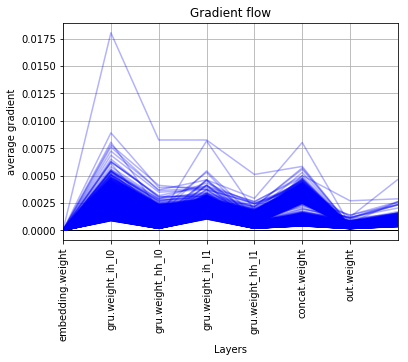

In [34]:
clip=50.0
teacher_forcing_ratio=1.0
learning_rate=0.0001
decoder_learning_ratio=5.0
n_iteration=3000
print_every=1
save_every=200

save_dir="not defined"

encoder.train()
decoder.train()

# encoder.cuda()
# decoder.cuda()

encoder_optimizer=torch.optim.Adam(encoder.parameters(),lr=learning_rate)
decoder_optimizer=torch.optim.Adam(decoder.parameters(),lr=learning_rate*decoder_learning_ratio)

plotter=VisdomLinePlotter('main')


trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)





In [35]:
encoder.eval()
decoder.eval()

LuongAttnDecoderRNN(
  (embedding): Embedding(7816, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=7816, bias=True)
  (attn): Attn()
)

In [36]:
searcher=GreedySearchDecoder(encoder,decoder)
evaluateInput(encoder,decoder,searcher,voc)

Human> hello
The Normalized Input Sentence: hello
Indexed sentence: [[787, 2]]
The Lengths tensor: tensor([2])
Decoder hidden state: tensor([[[ 0.6900, -0.0672,  0.2335, -0.2118,  0.0102,  0.0275,  0.3303,
           0.2687,  0.3290, -0.1629,  0.0191, -0.2451, -0.4923, -0.3990,
          -0.0548,  0.5105, -0.0763,  0.4938,  0.3577, -0.2208,  0.2920,
           0.1379, -0.1821,  0.2260, -0.0721, -0.2554, -0.2657,  0.0326,
          -0.4042,  0.0902, -0.2439, -0.3453, -0.3522,  0.3463,  0.4994,
          -0.0085,  0.1932,  0.2056,  0.5034, -0.1016,  0.1220, -0.0847,
          -0.5088, -0.1127, -0.1530,  0.2237, -0.3991,  0.2472,  0.4362,
          -0.4280, -0.3719,  0.3951,  0.1783, -0.4633, -0.2265,  0.1252,
          -0.3185, -0.1368, -0.1236, -0.1177, -0.0124,  0.0987, -0.4224,
          -0.2099,  0.0366, -0.2663, -0.3907,  0.1264, -0.0055,  0.2324,
           0.1507,  0.4044,  0.0443,  0.1641,  0.0776, -0.3851,  0.0276,
           0.0700,  0.1899, -0.0119,  0.3572, -0.2555, -0.2948, 

       grad_fn=<SliceBackward>)
Decoder's Input: tensor([[1]], device='cuda:0')
Decoder Output: tensor([[9.1629e-08, 9.4176e-08, 5.8350e-04,  ..., 1.5006e-05, 3.2877e-07,
         7.0421e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[4.5308e-08, 4.7355e-08, 1.9065e-02,  ..., 1.5049e-06, 1.7371e-06,
         7.2217e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[3.1102e-10, 3.1412e-10, 8.9124e-01,  ..., 9.9455e-09, 9.8980e-09,
         8.9740e-09]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[1.8648e-09, 1.6038e-09, 2.8965e-02,  ..., 1.6922e-07, 8.4043e-08,
         2.0183e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[2.6685e-10, 3.0087e-10, 8.9815e-01,  ..., 3.4600e-09, 8.0961e-09,
         1.0341e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[3.7604e-09, 3.9795e-09, 3.4141e-02,  ..., 1.3909e-07, 2.1025e-07,
         3.1572e-07]], device='cuda:0',

       device='cuda:0', grad_fn=<SliceBackward>)
Decoder's Input: tensor([[1]], device='cuda:0')
Decoder Output: tensor([[7.8787e-07, 7.3143e-07, 3.2763e-04,  ..., 5.6283e-06, 1.5250e-07,
         2.9884e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[7.2249e-09, 6.9449e-09, 1.1231e-01,  ..., 1.7195e-08, 2.8996e-08,
         2.1519e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[7.3648e-10, 8.8344e-10, 4.9490e-01,  ..., 6.9793e-09, 4.8956e-09,
         2.3148e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[4.2466e-11, 4.6860e-11, 3.2519e-02,  ..., 4.1080e-09, 8.6747e-10,
         4.9245e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[8.7441e-10, 1.1589e-09, 6.6313e-01,  ..., 7.3737e-09, 1.9380e-08,
         3.9711e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[7.4572e-11, 9.0499e-11, 7.8074e-02,  ..., 4.0753e-09, 1.8305e-09,
         5.8165e-08]],

       device='cuda:0', grad_fn=<SliceBackward>)
Decoder's Input: tensor([[1]], device='cuda:0')
Decoder Output: tensor([[3.7733e-08, 4.2165e-08, 5.3784e-04,  ..., 2.8930e-06, 1.8344e-07,
         3.0798e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[7.5724e-09, 7.0758e-09, 4.9618e-04,  ..., 1.4034e-08, 3.9268e-09,
         1.0273e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[1.0643e-07, 8.2680e-08, 8.7707e-04,  ..., 9.9009e-07, 1.7287e-07,
         7.5140e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[1.9703e-09, 2.1897e-09, 6.5013e-02,  ..., 3.0352e-08, 3.0272e-08,
         7.9633e-09]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[7.5034e-10, 8.9649e-10, 8.2128e-01,  ..., 4.7447e-09, 3.1738e-09,
         4.4919e-09]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Decoder Output: tensor([[2.1517e-10, 2.0492e-10, 9.3125e-02,  ..., 9.5543e-09, 6.5340e-09,
         1.8093e-08]],